In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.core.pylabtools import figsize
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import yaml
from tqdm import tqdm
import cv2
from src.models.metrics.metrics import calculate_metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import optuna
import plotly
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

%matplotlib inline

In [2]:
config_path = "../../../../config/config.yaml"

with open(config_path) as f:
    config = yaml.safe_load(f)

data_dir = Path(config['classifier_data'][f'data'])
image_dir = data_dir / "images"
label_dir = data_dir / "labels"

all_images = sorted(list(image_dir.glob("*.jpg")))
all_labels = sorted(list(label_dir.glob("*.txt")))

print(len(all_images))
print(len(all_labels))

823
823


In [3]:
all_data = [{"image": img, "label": lbl} for img, lbl in zip(all_images, all_labels)]

In [4]:
train_data, test_data = train_test_split(all_data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

x_train = [item["image"] for item in train_data]
y_train = [item["label"] for item in train_data]

x_val = [item["image"] for item in val_data]
y_val = [item["label"] for item in val_data]

x_test = [item["image"] for item in test_data]
y_test = [item["label"] for item in test_data]

print(f"x_train: {x_train[:5]}")
print(f"y_train: {y_train[:5]}")


print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

x_train: [PosixPath('/Users/kobe/Documents/UCLL/School 2024-2025/AI Applications/ai-app-bot-brigade/src/data/classifier_data/new/images/653_jpg.rf.f22f92cd057343ce14d6ba6b3a87b852.jpg'), PosixPath('/Users/kobe/Documents/UCLL/School 2024-2025/AI Applications/ai-app-bot-brigade/src/data/classifier_data/new/images/frame_5059_jpg.rf.8b96a3e2380408ba350384ea314944ac.jpg'), PosixPath('/Users/kobe/Documents/UCLL/School 2024-2025/AI Applications/ai-app-bot-brigade/src/data/classifier_data/new/images/Screenshot-2022-08-09-104752_jpg.rf.18e15c097fcbf9d161ab44ac4697baab.jpg'), PosixPath('/Users/kobe/Documents/UCLL/School 2024-2025/AI Applications/ai-app-bot-brigade/src/data/classifier_data/new/images/people-816-_jpg.rf.b88b2ddd52d0d6cc2bf157c0406da393.jpg'), PosixPath('/Users/kobe/Documents/UCLL/School 2024-2025/AI Applications/ai-app-bot-brigade/src/data/classifier_data/new/images/final1500208_jpg.rf.8ec3ae5fc10a1e43ded26a7ff59b0652.jpg')]
y_train: [PosixPath('/Users/kobe/Documents/UCLL/School 2

In [5]:
class FallImageDataset(Dataset):
    def __init__(self, images, labels, input_size):
        self.images = images
        self.labels = labels
        self.input_size = input_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label_path = self.labels[idx]

        # Load and preprocess image
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.input_size, self.input_size))
        image = image / 255.0

        # Load label
        with open(label_path, "r") as f:
            label = int(f.readline().strip().split()[0])

        return torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


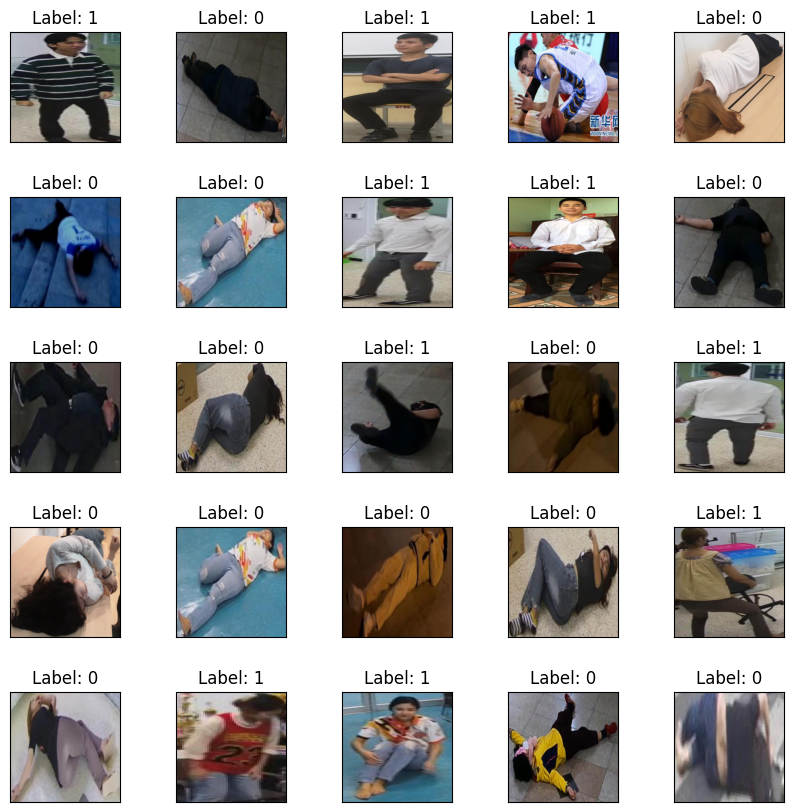

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    if i >= len(train_data):
        break

    # Load and display the image
    image_path = train_data[i]["image"]
    label_path = train_data[i]["label"]

    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the label
    with open(label_path, "r") as f:
        line = f.readline().strip().split()
        label = int(line[0])

    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [7]:
input_size = config['model']['classifier']['input_size']
batch_size = config['training_classifier']['batch_size']

print(input_size)
print(batch_size)

128
32


In [8]:
train_dataset = FallImageDataset(x_train, y_train, input_size)
val_dataset = FallImageDataset(x_val, y_val, input_size)
test_dataset = FallImageDataset(x_test, y_test, input_size)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [9]:
def make_model(trial, input_size):
    initial_out_channels = trial.suggest_categorical("out_channels", [16, 32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 2, 5, step=1)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            layers = []
            in_channels = 3
            
            for i in range(num_layers):
                out_channels = initial_out_channels * (2 ** i)
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(2, 2))
                in_channels = out_channels
                
            self.cnn = nn.Sequential(*layers)
            
            final_size = input_size // (2 ** num_layers)
            
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(final_size * final_size * in_channels, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 1),
                nn.Sigmoid()
            )
            
        def forward(self, x):
            x = self.cnn(x)
            x = self.classifier(x)
            return x
        
    return CNN()     

In [10]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    model = make_model(trial, input_size).to(config['system']['device'])

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.BCELoss()

    patience = 5  
    best_f1 = 0.0
    epochs_no_improve = 0

    for epoch in range(20):  
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{20}"):
            images, labels = batch
            images, labels = images.to(config['system']['device']), labels.to(config['system']['device'])

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        preds_binary = (np.array(all_preds) > 0.5).astype(int)
        f1 = calculate_metrics(preds_binary, all_labels)['f1_score']

        print(f"Epoch {epoch + 1}/{20} - Loss: {total_loss:.4f}, F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        trial.report(best_f1, epoch)

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            raise optuna.exceptions.TrialPruned()

    return best_f1

    


In [ ]:
study = optuna.create_study(direction='maximize', study_name=None)
study.optimize(objective, n_trials=10)
study.best_params
print(study.best_params)

In [22]:
best_trial = study.best_trial
best_params = best_trial.params

print("best hyperparameters:", best_params)

best hyperparameters: {'learning_rate': 0.00041458761275569076, 'weight_decay': 0.0006696849806701081, 'out_channels': 32, 'num_layers': 3, 'dropout': 0.4}


In [23]:
best_model = make_model(best_trial, input_size).to(config['system']['device'])

optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.BCELoss()

num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    best_model.train()

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        images, labels = batch
        images, labels = images.to(config['system']['device']), labels.to(config['system']['device'])

        optimizer.zero_grad()
        outputs = best_model(images).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {total_loss:.4f}")

Training Epoch 1/30: 100%|██████████| 19/19 [00:02<00:00,  7.40it/s]


Epoch 1/30 - Loss: 21.8374


Training Epoch 2/30: 100%|██████████| 19/19 [00:01<00:00, 13.11it/s]


Epoch 2/30 - Loss: 7.7306


Training Epoch 3/30: 100%|██████████| 19/19 [00:01<00:00, 13.55it/s]


Epoch 3/30 - Loss: 5.1363


Training Epoch 4/30: 100%|██████████| 19/19 [00:01<00:00, 13.48it/s]


Epoch 4/30 - Loss: 4.3826


Training Epoch 5/30: 100%|██████████| 19/19 [00:01<00:00, 13.61it/s]


Epoch 5/30 - Loss: 3.7919


Training Epoch 6/30: 100%|██████████| 19/19 [00:01<00:00, 13.48it/s]


Epoch 6/30 - Loss: 2.9451


Training Epoch 7/30: 100%|██████████| 19/19 [00:01<00:00, 13.58it/s]


Epoch 7/30 - Loss: 2.9604


Training Epoch 8/30: 100%|██████████| 19/19 [00:01<00:00, 13.70it/s]


Epoch 8/30 - Loss: 2.3549


Training Epoch 9/30: 100%|██████████| 19/19 [00:01<00:00, 13.39it/s]


Epoch 9/30 - Loss: 1.6659


Training Epoch 10/30: 100%|██████████| 19/19 [00:01<00:00, 13.56it/s]


Epoch 10/30 - Loss: 1.2234


Training Epoch 11/30: 100%|██████████| 19/19 [00:01<00:00, 13.56it/s]


Epoch 11/30 - Loss: 0.7194


Training Epoch 12/30: 100%|██████████| 19/19 [00:01<00:00, 13.64it/s]


Epoch 12/30 - Loss: 1.0042


Training Epoch 13/30: 100%|██████████| 19/19 [00:01<00:00, 13.57it/s]


Epoch 13/30 - Loss: 0.9414


Training Epoch 14/30: 100%|██████████| 19/19 [00:01<00:00, 13.54it/s]


Epoch 14/30 - Loss: 0.7115


Training Epoch 15/30: 100%|██████████| 19/19 [00:01<00:00, 13.62it/s]


Epoch 15/30 - Loss: 0.4932


Training Epoch 16/30: 100%|██████████| 19/19 [00:01<00:00, 13.62it/s]


Epoch 16/30 - Loss: 0.3026


Training Epoch 17/30: 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]


Epoch 17/30 - Loss: 0.2573


Training Epoch 18/30: 100%|██████████| 19/19 [00:01<00:00,  9.71it/s]


Epoch 18/30 - Loss: 0.2616


Training Epoch 19/30: 100%|██████████| 19/19 [00:01<00:00,  9.89it/s]


Epoch 19/30 - Loss: 0.6825


Training Epoch 20/30: 100%|██████████| 19/19 [00:01<00:00,  9.99it/s]


Epoch 20/30 - Loss: 0.6746


Training Epoch 21/30: 100%|██████████| 19/19 [00:01<00:00,  9.98it/s]


Epoch 21/30 - Loss: 0.4330


Training Epoch 22/30: 100%|██████████| 19/19 [00:01<00:00,  9.86it/s]


Epoch 22/30 - Loss: 0.2504


Training Epoch 23/30: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


Epoch 23/30 - Loss: 0.2515


Training Epoch 24/30: 100%|██████████| 19/19 [00:01<00:00, 10.06it/s]


Epoch 24/30 - Loss: 0.2261


Training Epoch 25/30: 100%|██████████| 19/19 [00:01<00:00,  9.87it/s]


Epoch 25/30 - Loss: 0.1976


Training Epoch 26/30: 100%|██████████| 19/19 [00:01<00:00,  9.84it/s]


Epoch 26/30 - Loss: 0.1737


Training Epoch 27/30: 100%|██████████| 19/19 [00:01<00:00,  9.82it/s]


Epoch 27/30 - Loss: 0.0873


Training Epoch 28/30: 100%|██████████| 19/19 [00:01<00:00,  9.90it/s]


Epoch 28/30 - Loss: 0.0873


Training Epoch 29/30: 100%|██████████| 19/19 [00:01<00:00,  9.94it/s]


Epoch 29/30 - Loss: 0.0737


Training Epoch 30/30: 100%|██████████| 19/19 [00:01<00:00,  9.83it/s]

Epoch 30/30 - Loss: 0.0651


In [24]:
best_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Testing"):
        images, labels = batch
        images, labels = images.to(config['system']['device']), labels.to(config['system']['device'])

        outputs = best_model(images).squeeze(1)
        preds = (outputs > 0.5).cpu().numpy().astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate and display metrics
test_metrics = calculate_metrics(all_preds, all_labels)
print("Test Metrics:", test_metrics)


Testing: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

Test Metrics: {'precision': 0.8840579710144928, 'recall': 0.9242424242424242, 'f1_score': 0.9037037037037037, 'accuracy': 0.9121621621621622}


In [28]:
def save_checkpoint(filename):
    checkpoint = {
        'classifier_state_dict': best_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    
save_checkpoint("best_model_optuna.pth")
print("Model saved as 'best_model_optuna.pth'")


Model saved as 'best_model_optuna.pth'


In [26]:
# loaded_model = make_model(best_trial, input_size).to(config['system']['device'])
# loaded_model.load_state_dict(torch.load("best_model_optuna.pth"))
# loaded_model.eval()


# self.input_size = self.config['model']['classifier']['input_size']
        # self.classifier = make_model(trial=None, input_size=self.input_size).to(self.device)
        # self.classifier.load_state_dict(torch.load(model_path, map_location=self.device))
        # self.classifier.eval()
model_path = "best_model_optuna"
loaded_model = make_model(best_trial, input_size).to(config['system']['device'])
checkpoint = torch.load(model_path, map_location=config['system']['device'])
loaded_model.load_state_dict(checkpoint['classifier_state_dict'])
loaded_model.eval()

/var/folders/f6/cqgl3gc517zb0rzw3ms24b9r0000gn/T/ipykernel_86975/697124152.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, i

In [27]:

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        images, labels = batch
        images, labels = images.to(config['system']['device']), labels.to(config['system']['device'])

        outputs = loaded_model(images).squeeze(1)
        preds = (outputs > 0.5).cpu().numpy().astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

test_metrics = calculate_metrics(all_preds, all_labels)
print("Test Metrics:", test_metrics)

Testing: 100%|██████████| 3/3 [00:00<00:00, 10.37it/s]

Test Metrics: {'precision': 0.9743589743589743, 'recall': 0.8444444444444444, 'f1_score': 0.9047619047619048, 'accuracy': 0.9036144578313253}


In [17]:
del study